In [1]:
%pylab inline
import numpy as np
import theano
import theano.tensor as T
from theano import pp
from scipy.spatial.distance import pdist, cdist
import sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
# now the actual distance function
k = T.dvector('k')
x1 = T.dmatrix('x1')
x2 = T.dmatrix('x2')
scale = T.scalar('scale')


lamb = scale/((x1-x2)**2).sum(1)

lpoi = T.sum(k * T.log(lamb) - lamb - T.gammaln(k+1))
lpoi_f = theano.function([scale, k, x1, x2], lpoi)
lpoi_grad = T.grad(lpoi, x2)
lpoi_grad_f = theano.function([scale, k, x1, x2], lpoi_grad)

<matplotlib.colorbar.Colorbar instance at 0x7f0580902758>

/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


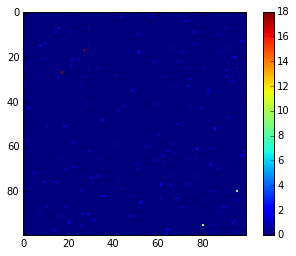

In [3]:
N = 100 
BATCH_SIZE = 10
DIM = 3
SCALE = 20.0
# fake data
xtrue = np.random.normal(0, 10, (N, DIM))

truedist = cdist(xtrue, xtrue,  'euclidean').astype(np.float64)**2
truedist[np.diag_indices(N)] = 1e10
obs = np.round(SCALE/truedist)
pylab.imshow(obs, interpolation='nearest')
pylab.colorbar()

In [4]:
def flatten(obs, x):
    N = len(x)
    Na = N*(N-1)/2
    x1flat = np.zeros((Na, x.shape[1]))
    x2flat = np.zeros((Na, x.shape[1]))
    
    obsflat = np.zeros((Na)) 
    pos = 0
    for i in range(N):
        for j in range(N):
            if j > i:
                obsflat[pos] = obs[i, j]
                x1flat[pos] = x[i]
                x2flat[pos] = x[j]
                pos += 1
    return x1flat, x2flat, obsflat

def total_ll(scale, obs, x):
    x1, x2, k = flatten(obs, x)
    return lpoi_f(scale, k, x1, x2)
    
x1flat, x2flat, kflat = flatten(obs, xtrue)   
#print np.sum((x1flat -x2flat)**2, axis=1)
print total_ll(SCALE, obs, xtrue)

-392.341996556


In [21]:

ITERS = 2000000
xk = np.random.normal(0, 10, (N, DIM))

val_present = np.random.rand(N, N) < 1.1

alpha = 0.1
num_batches =  N//BATCH_SIZE

for k in range(ITERS):
    # pick fixed indicies
    perm = np.random.permutation(N)
    point_subsets = np.split(perm[:num_batches*BATCH_SIZE], num_batches)
    
    for fixed_idx, change_idx in zip(point_subsets[:-1], point_subsets[1:]): 
        points = np.array([(q, r) for q, r in zip(fixed_idx, change_idx) if val_present[q, r] ])
        
        fixed_vals = xk[points[:, 0]]
        xk_v = xk[points[:, 1]] 
        ks = np.array([obs[p[0], p[1]] for p in points])
        
        alpha_k = alpha * (1-1e-6)**k
        grad =  lpoi_grad_f(SCALE, ks, fixed_vals, xk_v)
        xk[change_idx] = xk_v + alpha_k * grad
        
    if k % 1000 == 0:
        obsest = forward_model_lamb(SCALE, xk )
        l1err = np.sum(np.abs(obsest - obs))
        print k, alpha_k, total_ll(SCALE, obs, xk), l1err
    
    

0 0.1 -949.221434789 640.0
1000 0.0999000499334 -834.660416572 436.0
2000 0.0998001997669 -801.411773906 406.0
3000 0.0997004494008 -779.394831526 378.0
4000 0.0996007987352 -760.243944135 342.0
5000 0.0995012476705 -741.878015027 314.0
6000 0.0994017961072 -715.71970249 292.0
7000 0.0993024439457 -698.663326456 262.0
8000 0.0992031910869 -688.089020478 252.0
9000 0.0991040374313 -678.91991055 248.0
10000 0.0990049828799 -669.856754711 234.0
11000 0.0989060273335 -660.625291682 232.0
12000 0.0988071706933 -652.779696221 230.0
13000 0.0987084128604 -644.722717972 220.0
14000 0.098609753736 -635.430675172 218.0
15000 0.0985111932214 -626.14312904 216.0
16000 0.0984127312182 -614.376364899 214.0
17000 0.0983143676278 -599.558520872 212.0
18000 0.0982161023518 -542.285565074 202.0
19000 0.0981179352921 -569.685619899 206.0
20000 0.0980198663504 -660.107217491 204.0
21000 0.0979218954287 -656.550358924 202.0
22000 0.097824022429 -653.095481462 202.0
23000 0.0977262472534 -649.724788221 202.

<matplotlib.colorbar.Colorbar instance at 0x7f054e1d5c68>

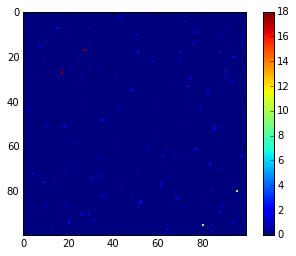

In [22]:
def forward_model_lamb(SCALE, x ):
    estdist = cdist(x, x,  'euclidean').astype(np.float64)**2
    estdist[np.diag_indices(N)] = 1e10
    obsest = np.round(SCALE/estdist)
    return obsest
obsest = forward_model_lamb(SCALE,xk )

pylab.imshow(obsest, interpolation='nearest')
pylab.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f054df131b8>

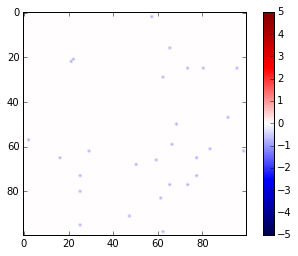

In [24]:
pylab.imshow(obsest - obs, cmap=pylab.cm.seismic, vmin=-5, vmax=5)
pylab.colorbar()

In [31]:
a = np.arange(10*8).reshape(10, 8)
b = np.array([[1,2], [3,4]])
a[b[:, 0], b[: 1]]

array([[ 9, 26]])